In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV, ElasticNet, HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import lilliefors, het_white, acorr_breusch_godfrey
from scipy import stats
from scipy.stats import uniform, randint

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
SEED = 23

In [2]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    return ratio, df_win

In [3]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

In [4]:
def normality_tests(data):
    """
    Perform various statistical tests to assess the normality of a given dataset.

    This function conducts the following normality tests on the provided data:
    1. Shapiro-Wilk Test
    2. Kolmogorov-Smirnov Test
    3. Anderson-Darling Test
    4. Lilliefors Test
    5. D’Agostino’s K-squared Test

    Each test provides different insights into the normality of the distribution 
    of the dataset. The function prints the test statistic and p-value for each test.

    Parameters:
    data (array-like): A sequence of numerical data points. The data should be a 1D array-like 
                       structure (e.g., Python list, NumPy array, or Pandas Series).

    Returns:
    None: This function only prints the results of the normality tests to the console.
    """
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest((data - np.mean(data)) / np.std(data), 'norm')
    print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}')

    # Anderson-Darling Test
    anderson_result = stats.anderson(data, dist='norm')
    print(f'Anderson-Darling Test: Statistic={anderson_result.statistic}')
    for i in range(len(anderson_result.critical_values)):
        sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
        print(f'At a significance level of {sl}, the critical value is {cv}.')

    # Lilliefors Test
    lilliefors_stat, lilliefors_p = lilliefors(data)
    print(f'Lilliefors Test: Statistic={lilliefors_stat}, p-value={lilliefors_p}')

    # D’Agostino’s K-squared Test
    dagostino_stat, dagostino_p = stats.normaltest(data)
    print(f"D'Agostino's K-squared Test: Statistic={dagostino_stat}, p-value={dagostino_p}")

In [5]:
def heatmap_spearman_significance(df):
    """
    Generate a heatmap displaying the Spearman's rank correlation coefficients 
    for each pair of variables in the provided DataFrame, with p-values and 
    significance levels annotated within each cell. Also, return a DataFrame with 
    the Spearman's rank correlation coefficients and p-values for each pair of variables.

    Parameters:
    df (DataFrame): A pandas DataFrame containing the variables for which correlations 
                    are to be calculated. The DataFrame should contain only numeric 
                    columns.

    Returns:
    DataFrame: A DataFrame containing the Spearman's rank correlation coefficients and 
               p-values for each pair of variables.
    """
    # Initialize matrices
    correlations = df.corr(method='spearman')
    annotations = pd.DataFrame(index=df.columns, columns=df.columns)
    results = []

    # Calculate Spearman correlation and p-values, format annotations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                corr, p_val = stats.spearmanr(df[col1].dropna(), df[col2].dropna())
                # Determine the significance level
                if p_val < 0.01:
                    sig = '***'
                elif p_val < 0.05:
                    sig = '**'
                elif p_val < 0.1:
                    sig = '*'
                else:
                    sig = ''
                # Format annotation with correlation and p-value
                annotations.at[col1, col2] = f'{corr:.2f}\n({p_val:.3f}){sig}'
                # Append results to list
                results.append({'Pair': f'{col1}-{col2}', 'Correlation': corr, 'P-value': p_val})
            else:
                annotations.at[col1, col2] = ''

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlations, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=annotations, mask=mask, cmap='coolwarm', fmt='', cbar_kws={'label': 'Spearman Correlation Coefficient'})
    plt.title("Spearman's Rank Correlation Heatmap with P-value and Significance Annotations")
    plt.show()

    # Convert results list to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df.set_index('Pair')

In [6]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.
    to_delete: list
        A list of removed variables. 

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    to_delete = [] 
    
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]
            to_delete.append(var)
    print("Remaining columns:", df.columns)
    return df, to_delete

In [7]:
def linreg_p_values(model, X, y):
    """
    Calculate p-values for a linear regression model's coefficients.

    This function fits a linear regression model using the provided data and
    calculates the p-values for each predictor's coefficient. It assumes 
    that the model passed as an argument is an instance of a linear regression
    model from a library like sklearn, and that `X` and `y` are compatible
    with this model.

    Parameters:
    model: A linear regression model instance from sklearn or similar library.
           The model should not have been previously fitted.
    X: DataFrame or 2D array-like
       The input variables (predictors) for the regression model. If a DataFrame
       is used, columns should have names for predictor identification in the output.
    y: Array-like
       The target variable (response) for the regression model.

    Returns:
    final_df: DataFrame
              A pandas DataFrame containing the predictor names, estimated coefficients,
              t-statistics, and p-values for each predictor in the model.
    """
    # Fit the model to the data
    model.fit(X, y)
    coefficients = model.coef_
    predictions = model.predict(X)
    residuals = y - predictions
    
    # Calculate t-statistics 
    df = len(y) - 2 #degrees of freedom 
    rss = np.sum(residuals**2)
    stderr = np.sqrt(rss / df) / np.sqrt(np.sum((X - np.mean(X))**2))
    t_stat = coefficients / stderr
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stat]
    
    #Prepare final output
    data = {'Predictor': X.columns, 'coef': list(coefficients), \
            't-stat': list(t_stat), 'p-values': p_values}
    final_df = pd.DataFrame(data)
    return final_df

In [8]:
def test_regression(model, X_train, X_test, y_train, y_test, cv):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return mape
    
    #initialize the model
    model.fit(X_train, y_train)
    train_mse = -np.mean(cross_val_score(model, X_train, y_train, cv = cv, \
                                n_jobs = -1, scoring='neg_mean_squared_error'))
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    #Calculate scores
    test_mse = mean_squared_error(y_test, y_pred)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred)
    
    #
    score_names = ['train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_mape',\
                   'test_mape', 'train_r2', 'test_r2']
    results = [train_mse, test_mse, train_mae, test_mae, train_mape, test_mape, train_r2, test_r2]
    results_dict = {score_names[i]: [results[i]] for i in range(len(score_names))}
    return results_dict

In [9]:
class StatmodelsWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, use_wls=False):
        self.use_wls = use_wls
        self.model = None

    def fit(self, X, y):
        X = sm.add_constant(X)

        if self.use_wls:
            # Fit an OLS model to estimate residuals for WLS
            ols_model = sm.OLS(y, X).fit()
            residuals = ols_model.resid

            # Compute weights as the inverse of the squared residuals
            weights = 1 / (residuals ** 2 + np.finfo(float).eps)  # Adding epsilon to avoid division by zero

            # Fit the WLS model with the computed weights
            self.model = sm.WLS(y, X, weights=weights).fit()
        else:
            # Fit the OLS model
            self.model = sm.OLS(y, X).fit()

        return self

    def predict(self, X):
        X = sm.add_constant(X)
        return self.model.predict(X)

# Data import and basic analysis

In [10]:
# Load Boston housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)
df = pd.concat([X, y], axis=1).rename(columns={0:'Value'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Value       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [12]:
df.describe()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count 20640.000 20640.000 20640.000  20640.000   20640.000 20640.000   
mean      3.871    28.639     5.429      1.097    1425.477     3.071   
std       1.900    12.586     2.474      0.474    1132.462    10.386   
min       0.500     1.000     0.846      0.333       3.000     0.692   
25%       2.563    18.000     4.441      1.006     787.000     2.430   
50%       3.535    29.000     5.229      1.049    1166.000     2.818   
75%       4.743    37.000     6.052      1.100    1725.000     3.282   
max      15.000    52.000   141.909     34.067   35682.000  1243.333   

       Latitude  Longitude     Value  
count 20640.000  20640.000 20640.000  
mean     35.632   -119.570     2.069  
std       2.136      2.004     1.154  
min      32.540   -124.350     0.150  
25%      33.930   -121.800     1.196  
50%      34.260   -118.490     1.797  
75%      37.710   -118.010     2.647  
max      41.950   -114.310     5.000

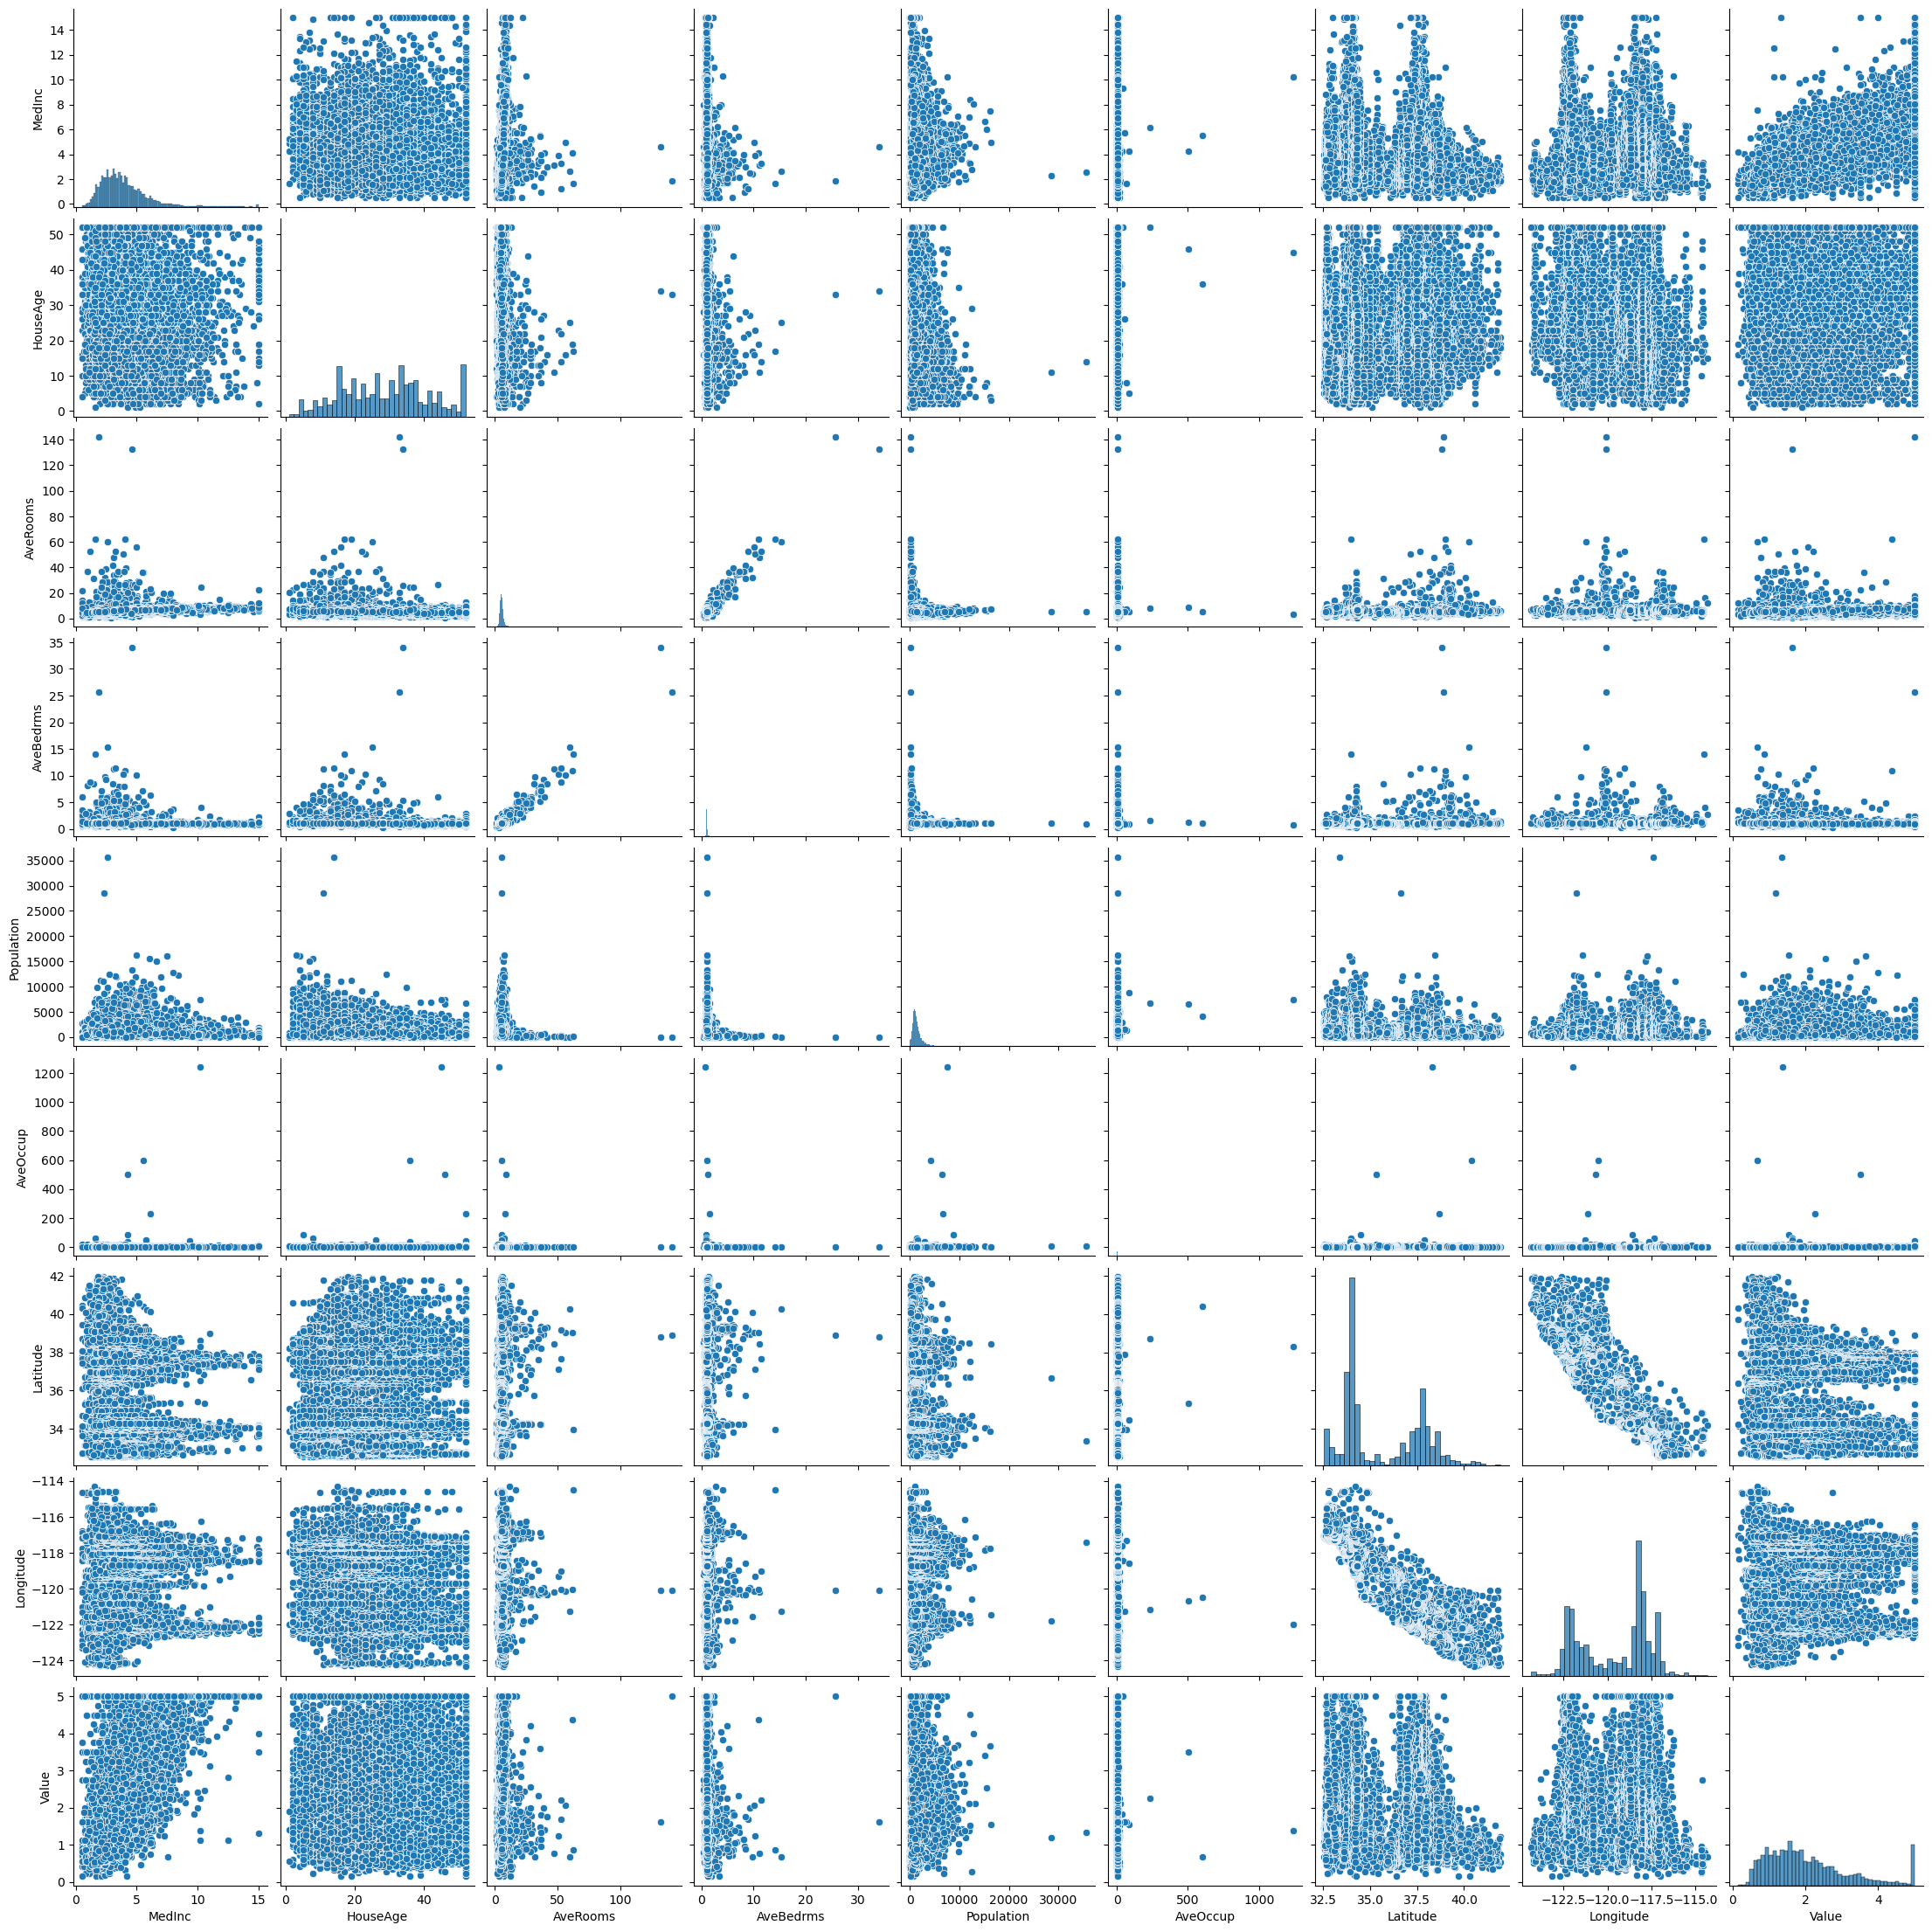

In [13]:
sns.pairplot(df)

In [14]:
#Cutting the outliers

df_std, ratio_std, outliers = Standard_Outlier_Remover(df, df.columns, 2)
print(f"Ratio of Outliers by Standard_Outlier_Remover:{ratio_std}")

Ratio of Outliers by Standard_Outlier_Remover:15.55


Spearman's correlation is a non-parametric measure of rank correlation that assesses how well the relationship between two variables can be described using a monotonic function. It evaluates the strength and direction of the association between two ranked variables, making it particularly useful for data that do not meet the assumptions of linear correlation.

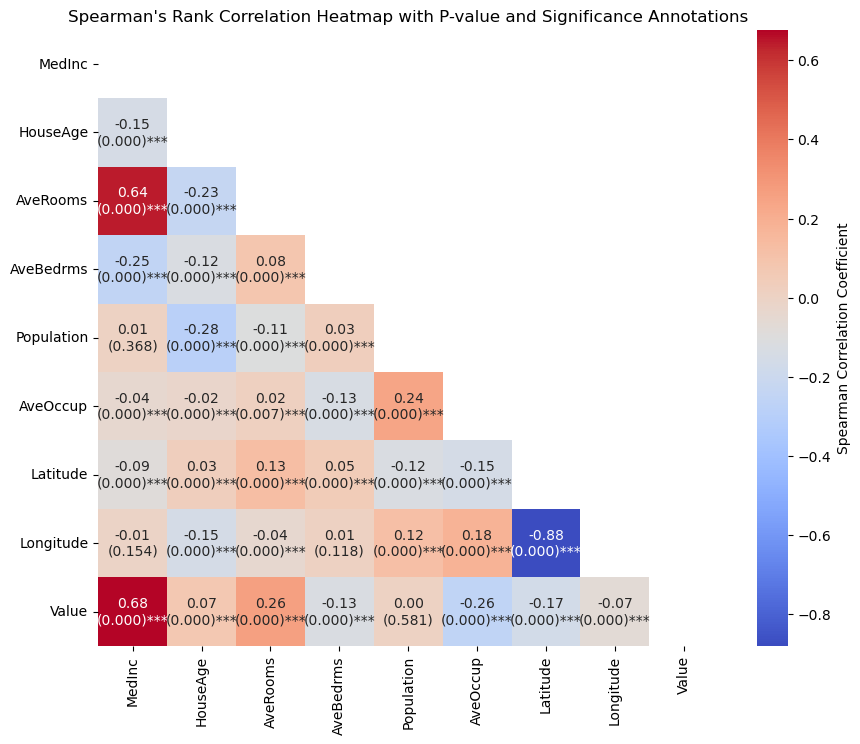

In [15]:
# Calculate Spearman correlation and p-values
spearman_df = heatmap_spearman_significance(df)

In [16]:
df_corr, corr_drop = high_corr(df, method='spearman', thsld=0.8, perc=0.95)

Removing Latitude with 0.95th percentile = -0.8249796157664303
Remaining columns: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Longitude', 'Value'],
      dtype='object')


# Feature selection and transformation

Lasso is a linear regression technique that includes a penalty equal to the absolute value of the magnitude of coefficients. This penalty can lead to some coefficients being shrunk to zero, effectively selecting a simpler model that includes only a subset of the features.

In [17]:
# Using LassoCV for feature selection
lasso = LassoCV(cv=5).fit(X, y)
lasso_drop = list(X.columns[lasso.coef_ == 0])
print("Features dropped by LassoCV:", lasso_drop)

Features dropped by LassoCV: ['AveBedrms']


In [18]:
#splitting data for training and testing
X_train, X_test, y_train, y_test= train_test_split(df_std.drop(corr_drop+lasso_drop+['Value']
                                                    , axis=1)
                                                    , df_std["Value"],test_size=0.1
                                                    , shuffle = True, random_state=SEED)

In [19]:
#Normalization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Linear Regression

Linear regression is a statistical method for modeling the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. The coefficients of the equation are derived from the data to minimize the sum of the squared differences between the observed and predicted values.

In [20]:
linreg = LinearRegression()
linreg.fit(X_train_std, y_train)
y_pred = linreg.predict(X_test_std)
y_pred_train = linreg.predict(X_train_std)
residuals = y_test - y_pred
residuals_train = y_train - y_pred_train

In [21]:
linreg_results = test_regression(linreg, X_train_std, X_test_std, y_train, y_test, 5)
linreg_results

{'train_mse': [0.3835291351468784],
 'test_mse': [0.3768228082076953],
 'train_mae': [0.4739993090436294],
 'test_mae': [0.4756508997848135],
 'train_mape': [31.625221258892438],
 'test_mape': [31.82419359623452],
 'train_r2': [0.5054143779562092],
 'test_r2': [0.5053847306627732]}

## Assumptions testing

### Linear relarionship

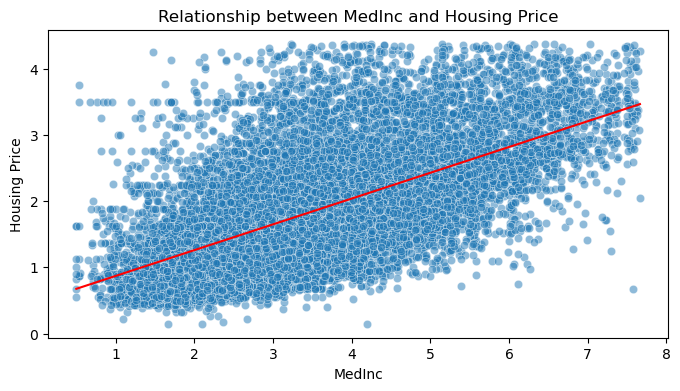

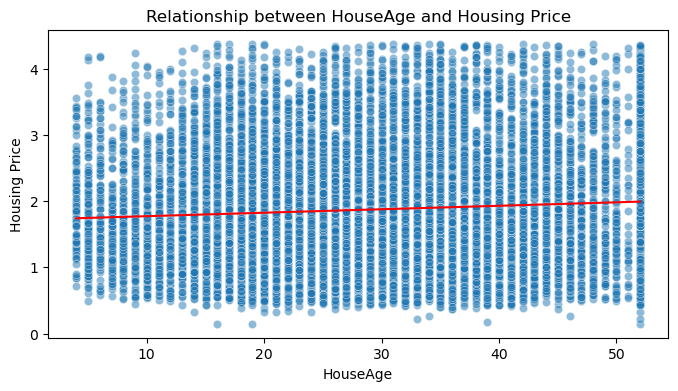

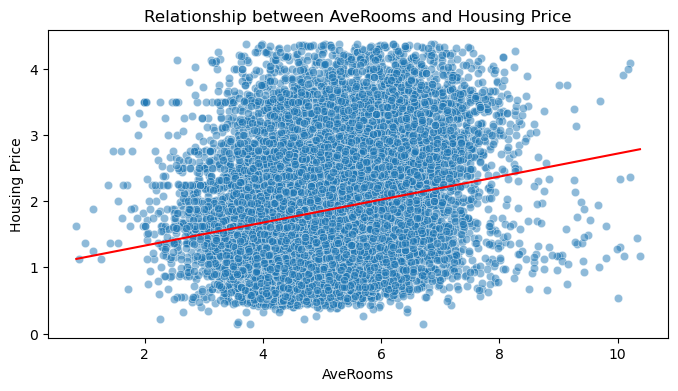

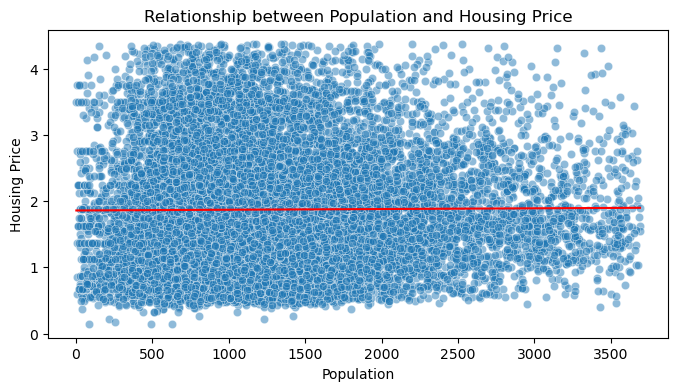

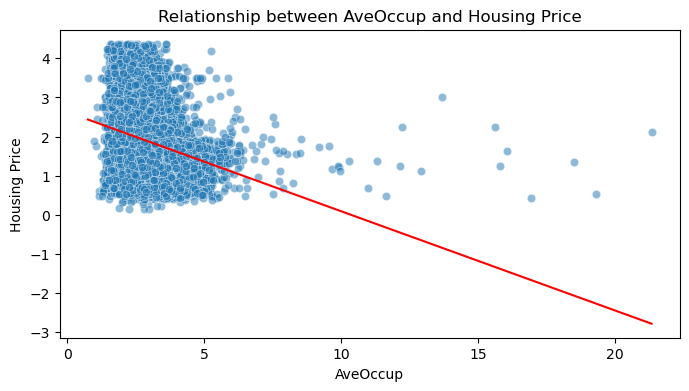

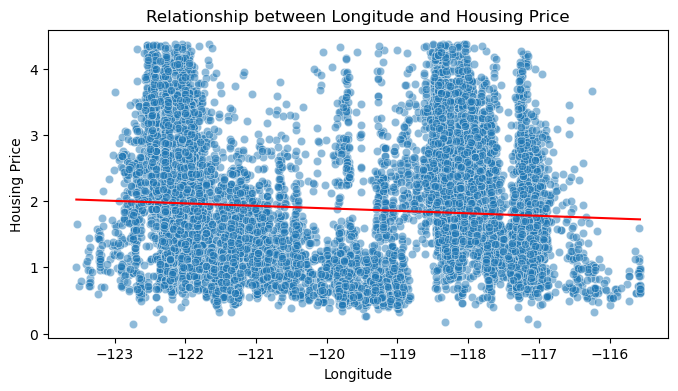

In [22]:
for column in X_train.columns:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(X_train[column], y_train)

    # Create scatter plot
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=X_train, x=column, y=y_train, alpha=0.5)

    # Calculate values for the fitted line
    x_values = np.linspace(X_train[column].min(), X_train[column].max(), 100)
    y_values = slope * x_values + intercept

    # Plot the fitted line
    plt.plot(x_values, y_values, color='red')

    # Add title and labels
    plt.title(f'Relationship between {column} and Housing Price')
    plt.xlabel(column)
    plt.ylabel('Housing Price')

    # Show the plot
    plt.show()

* High Correlation: A high absolute value of the correlation coefficient indicates a strong linear relationship.

* P-value: A small p-value (typically <0.05) suggests that the observed correlation is statistically significant.

### Normal distribution of residuals

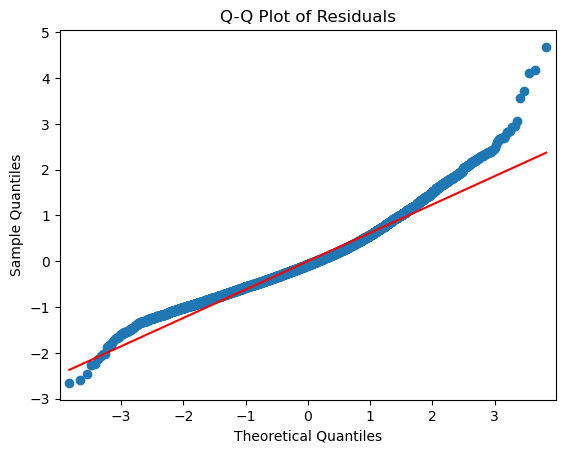

In [23]:
sm.qqplot(residuals_train, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

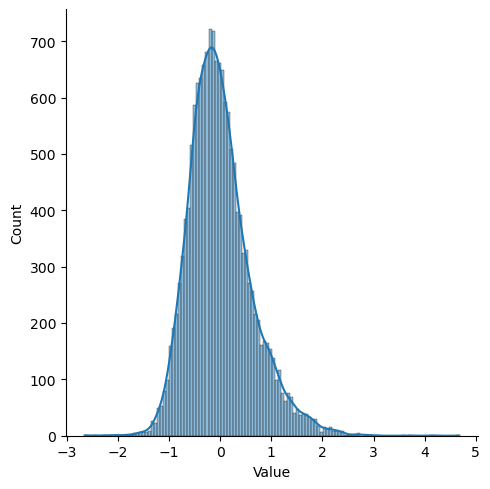

In [24]:
sns.displot(residuals_train, kde=True)

There is multiple test to assess distrubution of a population.
H0 - normal distribution of residuals.

H0 is rejected when p-values < 0.05.

In [25]:
normality_tests(residuals_train)

Shapiro-Wilk Test: Statistic=0.965532124042511, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.060580673882325686, p-value=1.726964742718164e-50
Anderson-Darling Test: Statistic=124.77580868436598
At a significance level of 15.0, the critical value is 0.576.
At a significance level of 10.0, the critical value is 0.656.
At a significance level of 5.0, the critical value is 0.787.
At a significance level of 2.5, the critical value is 0.918.
At a significance level of 1.0, the critical value is 1.092.
Lilliefors Test: Statistic=0.06058274014691778, p-value=0.0009999999999998899
D'Agostino's K-squared Test: Statistic=1940.5348668670565, p-value=0.0


C:\Users\Pavilion\anaconda3\envs\py38\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Homoscedasticity

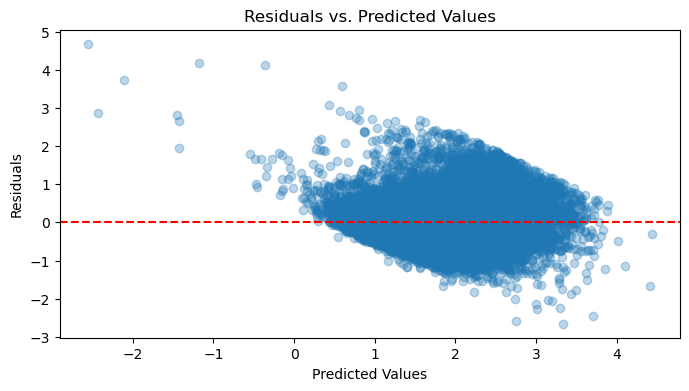

In [26]:
# Residuals vs Predicted values
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_train, residuals_train, alpha = 0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

* White's Test Statistic: A larger statistic suggests potential problems with heteroscedasticity.

* p-value: A small p-value (e.g., less than 0.05) indicates evidence against the null hypothesis of homoscedasticity, suggesting the presence of heteroscedasticity.

In [27]:
X_const = sm.add_constant(X_train)
white_test = het_white(residuals_train, X_const)
white_test_statistic, white_test_pvalue = white_test[:2]

print(f"White's Test Statistic: {white_test_statistic}")
print(f"White's Test p-value: {white_test_pvalue}")

White's Test Statistic: 2647.2104216100306
White's Test p-value: 0.0


### Autocorrelation of residuals

The Durbin-Watson test is a statistical test used to detect the presence of autocorrelation (a relationship between values separated from each other by a given time lag) at lag 1 in the residuals (prediction errors) from a regression analysis.The test statistic ranges from 0 to 4.

* A value of 2 indicates no autocorrelation.
* A value approaching 0 indicates positive autocorrelation.
* A value approaching 4 indicates negative autocorrelation.

In [28]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Durbin-Watson statistic: 2.0246463443370515


### Milticollinearity

The Variance Inflation Factor (VIF) is a measure that quantifies the extent of multicollinearity in an ordinary least squares regression analysis. Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. 
* VIF = 1: No correlation between the independent variable and the other variables.
* 1 < VIF < 5: Generally, a moderate correlation, and often not of concern.
* VIF >= 5: Indicates high multicollinearity (some sources may use 10 as the threshold), and the variable's coefficients may be poorly estimated due to the redundancy with other predictors.

In [29]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

      feature    VIF
0      MedInc 12.614
1    HouseAge  7.931
2    AveRooms 39.154
3  Population  5.019
4    AveOccup 13.346
5   Longitude 55.799


In [30]:
# Testing model's performance without predictors with high VIF
X_train_vif, X_test_vif, y_train, y_test = train_test_split(df_std.drop(corr_drop+lasso_drop+['Value'
                                                                                     , 'AveRooms'
                                                                                     , 'Longitude']
                                                    , axis=1)
                                                    , df_std["Value"],test_size=0.1
                                                    , shuffle = True, random_state=SEED)
scaler_vif = StandardScaler()
X_train_std_vif = scaler_vif.fit_transform(X_train_vif)
X_test_std_vif = scaler_vif.transform(X_test_vif)

linreg_vif_results = test_regression(linreg, X_train_std_vif, X_test_std_vif, y_train, y_test, 5)
linreg_vif_results

{'train_mse': [0.41006574653162],
 'test_mse': [0.3989543050113758],
 'train_mae': [0.49445756549473435],
 'test_mae': [0.4928465094242139],
 'train_mape': [33.52042418618515],
 'test_mape': [33.53229091822598],
 'train_r2': [0.4711168903311447],
 'test_r2': [0.4763350659026855]}

## Coefficients

In [31]:
linreg_p_values(linreg, X_train, y_train)

C:\Users\Pavilion\anaconda3\envs\py38\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Predictor   coef  t-stat  p-values
0      MedInc  0.496 140.705     0.000
1    HouseAge  0.013  33.129     0.000
2    AveRooms -0.194 -43.726     0.000
3  Population  0.000  12.334     0.000
4    AveOccup -0.224 -38.754     0.000
5   Longitude -0.013  -4.960     0.000

Each standardized coefficient represents the change in the dependent variable, in standard deviations, for a one standard deviation increase in the predictor variable, holding all other predictors constant.

Because all predictors are on the same scale, standardized coefficients allow for direct comparison of the magnitude of the effect that each predictor has on the dependent variable.

In [32]:
std_coefs = linreg.coef_
std_incpt = linreg.intercept_
orig_coefs = std_coefs / scaler.scale_
orig_incpt = std_incpt - np.dot(orig_coefs, scaler.mean_)
pd.DataFrame({'Name': X_train.columns, 'True coef':orig_coefs})

Name  True coef
0      MedInc      0.354
1    HouseAge      0.001
2    AveRooms     -0.174
3  Population      0.000
4    AveOccup     -0.261
5   Longitude     -0.007

True coefficients represent the estimated change in the dependent variable for a one-unit increase in the independent variable, holding all other independent variables constant..

# Elastic Net

Elastic Net is a regularization technique used in linear regression that combines both L1 and L2 penalties of the Lasso and Ridge methods. It is useful when there are multiple correlated features; it tends to select groups of correlated variables and shrink less important features fully to zero.

In [33]:
param_grid = {
    'alpha': np.logspace(-4, 4, 10),  
    'l1_ratio': np.linspace(0.01, 1.0, 10)  
}

grid = GridSearchCV(estimator=ElasticNet(max_iter=10000, random_state = SEED), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best score MSE:", -grid.best_score_) 

Best parameters: {'alpha': 0.005994842503189409, 'l1_ratio': 0.01}
Best score MSE: 0.5579835279370906


In [34]:
elastic_net = grid.best_estimator_
elastic_net_results = test_regression(elastic_net, X_train_std, X_test_std, y_train, y_test, 5)
elastic_net_results

{'train_mse': [0.38357130343309087],
 'test_mse': [0.3769047098672154],
 'train_mae': [0.4742656756935567],
 'test_mae': [0.47594227117849663],
 'train_mape': [31.687185427517267],
 'test_mape': [31.897150608460663],
 'train_r2': [0.5053564686535496],
 'test_r2': [0.5052772270549759]}

# Polynominal Regression

Polynomial regression is a form of linear regression in which the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial. It is used for fitting non-linear relationships in data.

In [35]:
for i in range(1,7):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=i, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_std)

    # Fit the model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_train, y_train)

    # Predict on training data
    X_poly_test = poly_features.transform(X_test_std)
    y_pred = poly_reg_model.predict(X_poly_test)

    # Calculate and print the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error {i}: {mse}")

Mean squared error 1: 0.3768228082076953
Mean squared error 2: 0.33534232344376663
Mean squared error 3: 0.3057318683771639
Mean squared error 4: 0.281925312258517
Mean squared error 5: 0.2836537753595192
Mean squared error 6: 0.7509069856019244


In [36]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=4, include_bias=True)
X_train_std_poly = poly_features.fit_transform(X_train_std)
X_test_std_poly = poly_features.transform(X_test_std)

# Fit the model
linreg_poly_results = test_regression(linreg, X_train_std_poly, X_test_std_poly, y_train, y_test, 5)
linreg_poly_results

{'train_mse': [0.4275791097945546],
 'test_mse': [0.2819253122584931],
 'train_mae': [0.39121687320888787],
 'test_mae': [0.4017861503306207],
 'train_mape': [25.25998736523659],
 'test_mape': [25.825078114660872],
 'train_r2': [0.6411986897993538],
 'test_r2': [0.6299465923547336]}

# SVR

SVR is a type of Support Vector Machine (SVM) that is used for regression problems. It works by fitting the best line within a threshold value where the distances from the closest points of the data set (known as support vectors) to this line are minimized.

In [37]:
#Linear regressor
svr_lin = SVR(kernel='linear')
svr_lin_results = test_regression(svr_lin, X_train_std, X_test_std, y_train, y_test, 5)
svr_lin_results

{'train_mse': [0.3894001676645488],
 'test_mse': [0.38114920539812575],
 'train_mae': [0.46924258678282016],
 'test_mae': [0.4692086889724462],
 'train_mape': [29.83201183576003],
 'test_mape': [29.85252612095576],
 'train_r2': [0.49771548657756515],
 'test_r2': [0.4997059286768142]}

In [38]:
#Non-linear regressor
svr_rbf = SVR(kernel='rbf') 
svr_rbf_results = test_regression(svr_rbf, X_train_std, X_test_std, y_train, y_test, 5)
svr_rbf_results

{'train_mse': [0.28212233960964295],
 'test_mse': [0.2716101827468808],
 'train_mae': [0.36836556361352174],
 'test_mae': [0.38573342011322],
 'train_mape': [22.436539042039183],
 'test_mape': [23.55680670387456],
 'train_r2': [0.6569555273036523],
 'test_r2': [0.6434861670580312]}

# WLS

WLS is a variant of linear regression that assigns different weights to different data points. It is particularly useful when the residuals (errors) have non-constant variance, allowing for a better fit by giving less weight to points with higher variance.

In [39]:
# Initialize the WLS wrapper
wls = StatmodelsWrapper(use_wls=True)
wls_results = test_regression(wls, X_train_std, X_test_std, y_train, y_test, 5)
wls_results

{'train_mse': [0.38352533157027374],
 'test_mse': [0.37681774518280786],
 'train_mae': [0.47400002526187685],
 'test_mae': [0.4756502638516323],
 'train_mape': [31.625329783018323],
 'test_mape': [31.823702951486588],
 'train_r2': [0.5054140957228699],
 'test_r2': [0.5053913763576829]}

# Huber

Huber Regression is a robust regression technique that is less sensitive to outliers in data. It combines the properties of both ridge regression and least squares, adjusting the loss function to reduce the weight given to outliers in the fitting process.

In [40]:
# Create and fit the Huber regressor
huber = HuberRegressor(alpha=0.0001, epsilon=1.35)
huber_results = test_regression(huber, X_train_std, X_test_std, y_train, y_test, 5)
huber_results

{'train_mse': [0.38738467475990135],
 'test_mse': [0.37916470068574615],
 'train_mae': [0.46944454902305055],
 'test_mae': [0.4696447449306791],
 'train_mape': [30.124896705078026],
 'test_mape': [30.1802517037558],
 'train_r2': [0.500292590739442],
 'test_r2': [0.5023107771929729]}

# Summary

In [44]:
model_results = [
   linreg_results, linreg_vif_results, elastic_net_results, linreg_poly_results, svr_lin_results,\
    svr_rbf_results, wls_results,  huber_results]

# Model names
model_names = ['Linear Regression', 'Linear VIF', 'Elastic Net', 'Polynominal Regression',\
              'Linear SVR', 'Non-linear SVR', 'WLS', 'Huber' ]

# Combine into a single DataFrame
df_list = [pd.DataFrame(results, index=[name]) for name, results in zip(model_names, model_results)]
combined_df = pd.concat(df_list)

combined_df.sort_values('test_mse')

train_mse  test_mse  train_mae  test_mae  train_mape  \
Non-linear SVR              0.282     0.272      0.368     0.386      22.437   
Polynominal Regression      0.428     0.282      0.391     0.402      25.260   
WLS                         0.384     0.377      0.474     0.476      31.625   
Linear Regression           0.384     0.377      0.474     0.476      31.625   
Elastic Net                 0.384     0.377      0.474     0.476      31.687   
Huber                       0.387     0.379      0.469     0.470      30.125   
Linear SVR                  0.389     0.381      0.469     0.469      29.832   
Linear VIF                  0.410     0.399      0.494     0.493      33.520   

                        test_mape  train_r2  test_r2  
Non-linear SVR             23.557     0.657    0.643  
Polynominal Regression     25.825     0.641    0.630  
WLS                        31.824     0.505    0.505  
Linear Regression          31.824     0.505    0.505  
Elastic Net                31.897     0.505    0.505  
Huber                      30.180     0.500    0.502  
Linear SVR                 29.853     0.498    0.500  
Linear VIF                 33.532     0.471    0.476

Taking into consideration that a significant part that assumtions for linear regression was not met, shows better results for non-linear models are expected. 

In [45]:
svr_rbf.coefs_

AttributeError: 'SVR' object has no attribute 'coefs_'